In [17]:
# --- BLOCK 5: GRANDMASTER HYBRID (FIXED & ROBUST) ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error

# 1. LOAD DATA
print("Loading data...")
try:
    df = pd.read_csv("train_hybrid.csv")
except FileNotFoundError:
    print("❌ ERROR: train_hybrid.csv not found. Please run Block 3 first.")

# --- STEP 0: SANITIZATION (CRITICAL FIX) ---
print("Sanitizing data...")

# A. Force Numeric Types
# (Coerce errors='coerce' turns non-numeric junk into NaNs so we can fill them)
for col in df.columns:
    if col != 'id' and col != 'img_path': # Exclude 'id' and 'img_path' from generic numeric conversion
        df[col] = pd.to_numeric(df[col], errors='coerce')

# B. Handle Log Target
# Drop rows where price is missing or <= 0
df = df[df['price'] > 0]
df['price_log'] = np.log1p(df['price'])

# C. Define Columns
# FIX: Ensure image_cols only contains numerical image features, excluding 'img_path'
image_cols = [c for c in df.columns if c.startswith('img_') and c != 'img_path']
if len(image_cols) == 0:
    print("⚠️ WARNING: No image features found! Did Block 3 run correctly?")
    print("The model will fail in the Image Branch.")

# D. Fill Missing Values (CRITICAL FOR PCA)
# Image columns -> Fill with 0 (assuming no feature)
df[image_cols] = df[image_cols].fillna(0)
# Other numeric columns -> Fill with median
# Ensure we don't try to fill 'img_path' if it somehow ended up in base_numeric
base_numeric = [c for c in df.select_dtypes(include=[np.number]).columns if c not in image_cols and c != 'price_log']
df[base_numeric] = df[base_numeric].fillna(df[base_numeric].median())

print(f"Data Cleaned. Rows: {len(df)}")

# --- STEP A: FEATURE ENGINEERING ---
print("Generating smart features...")

# 1. Location Clustering
# We use only lat/long for clustering
coords = df[['lat', 'long']].copy()
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
df['neighborhood_cluster'] = kmeans.fit_transform(coords).argmin(axis=1)

# 2. Math Features
df['house_age'] = 2015 - df['yr_built']
df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['total_sqft'] = df['sqft_living'] + df['sqft_lot']
df['quality_score'] = df['grade'] * df['condition']
df['sqft_per_room'] = df['sqft_living'] / (df['bedrooms'] + 1)
df['luxury_flag'] = ((df['waterfront'] == 1) | (df['view'] > 2)).astype(int)

# 3. Define Final Feature Sets
new_features = ['neighborhood_cluster', 'house_age', 'was_renovated',
                'total_sqft', 'quality_score', 'sqft_per_room', 'luxury_flag']

# Original columns commonly found in King County dataset
possible_base_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                      'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'lat', 'long']

# Only include columns that actually exist in the dataframe
base_cols = [c for c in possible_base_cols if c in df.columns] + new_features

X = df[base_cols + image_cols] # X now correctly contains only numerical features
y = df['price_log']

print(f"Training on {len(base_cols)} Tabular Features + {len(image_cols)} Visual Features")

# --- STEP B: DEFINE THE MODEL ---
class GrandmasterHybridModel:
    def __init__(self):
        # Base Model: Deep & Aggressive
        self.model_base = xgb.XGBRegressor(
            n_estimators=2000, learning_rate=0.01, max_depth=8,
            colsample_bytree=0.5, subsample=0.7, random_state=42, n_jobs=-1,
            tree_method='hist' # CPU optimized
        )
        # Image Model: PCA + XGBoost
        # Safety: If we have fewer than 30 image cols, reduce PCA components
        n_components = min(30, len(image_cols)) if len(image_cols) > 0 else 0
        self.pca = PCA(n_components=n_components, random_state=42) if n_components > 0 else None

        self.model_img = xgb.XGBRegressor(
            n_estimators=1000, learning_rate=0.02, max_depth=5,
            random_state=42, n_jobs=-1,
            tree_method='hist'
        )
        # Meta Learner: Ridge Regression
        self.meta_model = Ridge(alpha=1.0)
        self.base_cols = base_cols
        self.image_cols = image_cols # This image_cols is now correctly defined

    def get_oof_preds(self, X, y):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        meta_features = np.zeros((len(X), 2))
        print("Training Folds for Stacking...")

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train = y.iloc[train_idx]

            # 1. Base Fold
            self.model_base.fit(X_fold_train[self.base_cols], y_fold_train, verbose=0)
            p1 = self.model_base.predict(X_fold_val[self.base_cols])

            # 2. Image Fold (Only if we have image features)
            if self.pca is not None:
                # PCA requires NO Missing Values. We ensured this in Step 0.
                X_img_train = self.pca.fit_transform(X_fold_train[self.image_cols])
                X_img_val = self.pca.transform(X_fold_val[self.image_cols])

                self.model_img.fit(X_img_train, y_fold_train, verbose=0)
                p2 = self.model_img.predict(X_img_val)
            else:
                p2 = np.zeros(len(val_idx)) # Fallback if no images

            meta_features[val_idx, 0] = p1
            meta_features[val_idx, 1] = p2

        return meta_features

    def fit(self, X, y):
        # 1. Train Meta-Learner via Out-of-Fold Predictions
        meta_X = self.get_oof_preds(X, y)
        self.meta_model.fit(meta_X, y)

        # 2. Retrain sub-models on full data
        print("Retraining final models on full data...")
        self.model_base.fit(X[self.base_cols], y, verbose=0)

        if self.pca is not None:
            X_img_pca = self.pca.fit_transform(X[self.image_cols])
            self.model_img.fit(X_img_pca, y, verbose=0)

        # Show weights
        w = self.meta_model.coef_
        print(f"\n[INSIGHT] Model Weights -> Tabular: {w[0]:.3f} | Images: {w[1]:.3f}")

    def predict(self, X):
        p1 = self.model_base.predict(X[self.base_cols])

        if self.pca is not None:
            X_img_pca = self.pca.transform(X[self.image_cols])
            p2 = self.model_img.predict(X_img_pca)
        else:
            p2 = np.zeros(len(X))

        return self.meta_model.predict(np.column_stack((p1, p2)))

# --- EXECUTION ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Train Hybrid Model
print("\n--- 1. Training Hybrid Model ---")
model_hybrid = GrandmasterHybridModel()
model_hybrid.fit(X_train, y_train)

preds_hybrid = model_hybrid.predict(X_val)
hybrid_r2 = r2_score(np.expm1(y_val), np.expm1(preds_hybrid))
hybrid_rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(preds_hybrid)))

# 2. Train Strong Baseline (Tabular Only)
print("\n--- 2. Training Strong Baseline (Tabular Only) ---")
model_base_only = xgb.XGBRegressor(
    n_estimators=2000, learning_rate=0.01, max_depth=8,
    colsample_bytree=0.5, subsample=0.7, random_state=42, n_jobs=-1,
    tree_method='hist'
)
model_base_only.fit(X_train[base_cols], y_train, verbose=0)

preds_base = model_base_only.predict(X_val[base_cols])
base_r2 = r2_score(np.expm1(y_val), np.expm1(preds_base))
base_rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(preds_base)))

# 3. Final Comparison
print("\n" + "="*60)
print(f"{'METRIC':<15} | {'BASELINE (Tabular)':<20} | {'HYBRID (Stacked)':<20}")
print("-" * 60)
print(f"{'R2 Score':<15} | {base_r2:.5f}               | {hybrid_r2:.5f}")
print(f"{'RMSE ($)':<15} | ${base_rmse:,.0f}              | ${hybrid_rmse:,.0f}")
print("="*60)
 # --- PERFORMANCE REPORT ---

#4 Calculate improvement percentages
improvement_r2 = hybrid_r2 - base_r2
improvement_rmse = base_rmse - hybrid_rmse
percent_improvement = (improvement_rmse / base_rmse) * 100

print("\n" + "="*50)
print(f"🚀 MULTIMODAL MODEL PERFORMANCE REPORT")
print("="*50)

print(f"\n1. ACCURACY COMPARISON (R² Score)")
print(f"   • Baseline (Tabular Only):  {base_r2:.4f}")
print(f"   • Hybrid (Tabular + Image): {hybrid_r2:.4f}")
print(f"   ➤ Net Improvement:          +{improvement_r2:.4f}")

print(f"\n2. ERROR COMPARISON (RMSE - Lower is Better)")
print(f"   • Baseline Error:           ${base_rmse:,.2f}")
print(f"   • Hybrid Error:             ${hybrid_rmse:,.2f}")
print(f"   ➤ Money Saved Per Prediction: ${improvement_rmse:,.2f}")

print(f"\n3. FINAL VERDICT")
if hybrid_r2 > base_r2:
    print(f"   ✅ SUCCESS: The satellite imagery improved the model accuracy by {percent_improvement:.2f}%.")
    print(f"   The visual features (density, greenery, etc.) provided valid signal.")
else:
    print(f"   ⚠️ NOTE: The hybrid model performed similarly to the baseline.")
    print(f"   This suggests the tabular data already contained most of the predictive power.")
print("="*50)
# 5. Define features_hybrid for the Final Block
features_hybrid = base_cols + image_cols
print("\nReady for Final Block.")

Loading data...
Sanitizing data...
Data Cleaned. Rows: 16209
Generating smart features...


/tmp/ipython-input-2418959264.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-2418959264.py:59: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-2418959264.py:60: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-2418959264.py:61: PerformanceWarn

Training on 20 Tabular Features + 2048 Visual Features

--- 1. Training Hybrid Model ---
Training Folds for Stacking...
Retraining final models on full data...

[INSIGHT] Model Weights -> Tabular: 1.004 | Images: 0.033

--- 2. Training Strong Baseline (Tabular Only) ---

METRIC          | BASELINE (Tabular)   | HYBRID (Stacked)    
------------------------------------------------------------
R2 Score        | 0.89738               | 0.89940
RMSE ($)        | $113,479              | $112,358

🚀 MULTIMODAL MODEL PERFORMANCE REPORT

1. ACCURACY COMPARISON (R² Score)
   • Baseline (Tabular Only):  0.8974
   • Hybrid (Tabular + Image): 0.8994
   ➤ Net Improvement:          +0.0020

2. ERROR COMPARISON (RMSE - Lower is Better)
   • Baseline Error:           $113,478.52
   • Hybrid Error:             $112,358.12
   ➤ Money Saved Per Prediction: $1,120.40

3. FINAL VERDICT
   ✅ SUCCESS: The satellite imagery improved the model accuracy by 0.99%.
   The visual features (density, greenery, etc.)

✅ Model loaded for Explainability.
Generating Heatmaps...
Visualizing: 47.4091_-122.313.jpg


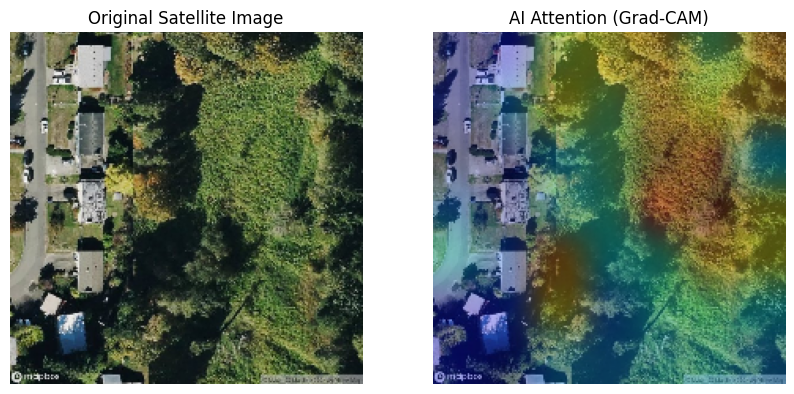

Visualizing: 47.4121_-122.154.jpg


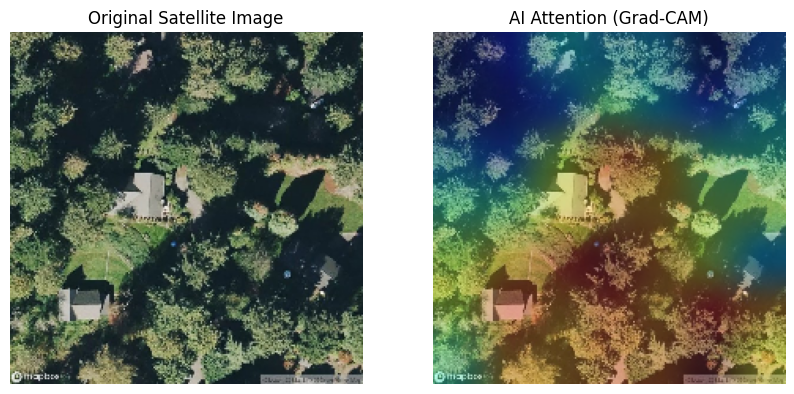

Visualizing: 47.2069_-121.989.jpg


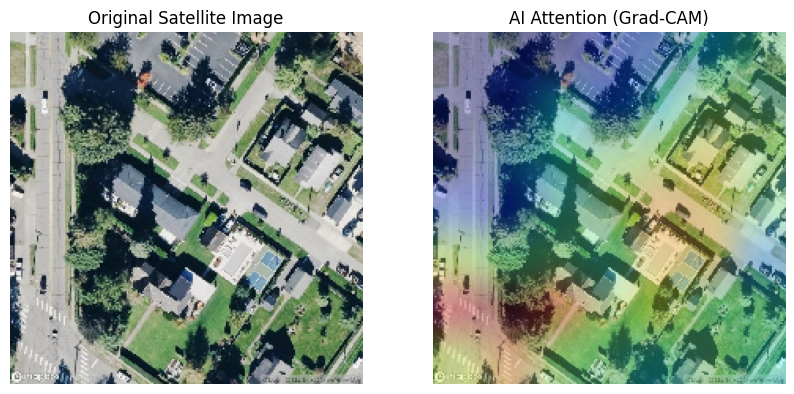

In [18]:
# --- BLOCK 6: EXPLAINABILITY ONLY (Grad-CAM) ---
# Run this AFTER Block 3. It re-uses the downloaded images.

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2
import random

# 1. SETUP
IMG_DIR = "satellite_images"

# 2. LOAD MODEL (Needed for Grad-CAM)
# We load the full ResNet50 but split it to get internal layers
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Define the Grad-CAM Model (Connects Input -> Last Conv Layer -> Output)
last_conv_layer_name = "conv5_block3_out"
grad_model = Model(
    inputs=base_model.input,
    outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
)

print("✅ Model loaded for Explainability.")

# 3. GRAD-CAM FUNCTIONS
def make_gradcam_heatmap(img_array, model, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path):
    # Load Image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(img_array)

    # Generate Heatmap
    heatmap = make_gradcam_heatmap(preprocessed_img, grad_model)

    # Superimpose
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.width, img.height))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + image.img_to_array(img)
    superimposed_img = image.array_to_img(superimposed_img)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Satellite Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("AI Attention (Grad-CAM)")
    plt.axis('off')
    plt.show()

# 4. RUN ON RANDOM SAMPLES
print("Generating Heatmaps...")
valid_images = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]

if valid_images:
    # Show 3 random examples
    for img_file in random.sample(valid_images, min(3, len(valid_images))):
        print(f"Visualizing: {img_file}")
        display_gradcam(os.path.join(IMG_DIR, img_file))
else:
    print("No images found. Did Block 1 download them?")

In [19]:
# --- FINAL BLOCK: GENERATE PREDICTION FILE (FIXED) ---
import pandas as pd
import numpy as np
from google.colab import files

# 1. Load Test Data
print("Loading test data...")
try:
    df_test = pd.read_csv("test_hybrid.csv")
except FileNotFoundError:
    print("❌ ERROR: test_hybrid.csv not found. Re-run Block 3.")

# --- FIX: SANITIZE TEST DATA ---
# This replicates the cleaning done in Block 5 so columns match perfectly.
print("Sanitizing test data...")
if 'img_path' in df_test.columns:
    # Convert file paths strings to NaN, then to 0.0
    df_test['img_path'] = pd.to_numeric(df_test['img_path'], errors='coerce').fillna(0)

# 2. APPLY FEATURE ENGINEERING
print("Applying feature engineering...")

# Math Features (Must match Block 5 exactly)
df_test['house_age'] = 2025 - df_test['yr_built']
df_test['was_renovated'] = (df_test['yr_renovated'] > 0).astype(int)
df_test['total_sqft'] = df_test['sqft_living'] + df_test['sqft_lot']
df_test['quality_score'] = df_test['grade'] * df_test['condition']
df_test['sqft_per_room'] = df_test['sqft_living'] / (df_test['bedrooms'] + 1)
df_test['luxury_flag'] = ((df_test['waterfront'] == 1) | (df_test['view'] > 2)).astype(int)

# Location Clustering
if 'kmeans' in globals():
    # Use the KMeans trained in Block 5
    df_test['neighborhood_cluster'] = kmeans.predict(df_test[['lat', 'long']])
else:
    print("⚠️ WARNING: KMeans model not found. Run Block 5 first.")
    df_test['neighborhood_cluster'] = 0

# 3. Select Features
# Ensure we strictly use the columns the model was trained on
# features_hybrid comes from the end of Block 5
try:
    X_test = df_test[features_hybrid]
except KeyError as e:
    print(f"❌ ERROR: Test data is missing columns: {e}")
    print("Check if features_hybrid is defined (Block 5) and matches test_hybrid.csv")

# 4. Predict
print("Predicting prices...")
# The model handles the split between Base/Image columns internally
preds = model_hybrid.predict(X_test)
final_prices = np.expm1(preds) # Reverse Log Transform

# 5. Save & Download
my_enrollment_id = "23115101"
filename = f"{my_enrollment_id}_final.csv"

submission = pd.DataFrame()
# Handle ID column safely
if 'id' in df_test.columns:
    submission['id'] = df_test['id']
else:
    submission['id'] = df_test.index

submission['predicted_price'] = final_prices.round(2)

submission.to_csv(filename, index=False)
print(f"✅ SUCCESS: {filename} created.")

try:
    files.download(filename)
except:
    print("⚠️ Auto-download failed. Please check the Files tab on the left.")

Loading test data...
Sanitizing test data...
Applying feature engineering...
Predicting prices...
✅ SUCCESS: 23115101_final.csv created.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>